# Boosting a decision stump

In [43]:
import graphlab
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd

# Getting the data ready

In [44]:
loans = graphlab.SFrame("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.gl/")
loans.save("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.csv", format="csv")
loans = pd.read_csv("E:\\Machine Learning\\U.W\\Classification\\lending-club-data.csv")

In [45]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### Extracting the target and the feature columns

In [46]:
features = ["grade", "term", "home_ownership", "emp_length"]

loans["safe_loans"] = loans["bad_loans"].apply(lambda x: +1 if x==0 else -1)
loans = loans.drop(["bad_loans"], axis=1)
target = "safe_loans"
loans = loans[features + [target]]

### Subsample dataset to make sure classes are balanced

In [47]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=42)
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                :", len(safe_loans)/float(len(loans_data))
print "Percentage of risky loans               :", len(risky_loans)/float(len(loans_data))
print "Total number of loans in our new dataset:", len(loans_data)

Percentage of safe loans                : 0.5
Percentage of risky loans               : 0.5
Total number of loans in our new dataset: 46300


### Transform categorical data into binary features

In [48]:
loans_data = risky_loans.append(safe_loans)

loans_data = pd.get_dummies(loans_data)

In [206]:
features = loans_data.columns.values
features = features[features != "safe_loans"]

features

array(['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year'], dtype=object)

### Train-test split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train_data, test_data = train_test_split(loans_data, test_size=0.2, random_state=42)

In [52]:
print len(train_data)/len(loans_data)
print len(test_data)/len(loans_data)

0.8
0.2


# Weighted decision trees

### Weighted error definition

$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$


### Write a function to compute weight of mistakes

$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$

$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

In [132]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1.
    arr1 = np.array(labels_in_node == +1)
    total_weight_positive = sum(data_weights[list(arr1)])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above.
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1.
    arr2 = np.array(labels_in_node == -1)
    total_weight_negative = sum(data_weights[list(arr2)])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above.
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    # class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive, +1)
    if weighted_mistakes_all_negative < weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative, -1)
    else:
        return (weighted_mistakes_all_positive, +1)

### Function to pick best feature to split on

In [134]:
def best_splitting_feature(data, features, target, data_weights):

    best_feature = None
    best_error = float("+inf")
    num_points = float(len(data))
    
    
    for feature in features:
        
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        arr1 = np.array(data[feature] == 0)
        arr2 = np.array(data[feature] == 1)
        
        left_data_weights = data_weights[list(arr1)]
        right_data_weights = data_weights[list(arr2)]
        
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        error = (left_weighted_mistakes + right_weighted_mistakes) / num_points
        
        if error < best_error:
            best_feature = feature
            best_error = error
            

    return best_feature

### Building the tree

In [135]:
def create_leaf(target_values, data_weights):
    leaf = {"splitting_feature": None,
           "is_leaf": True}
    
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    
    leaf["prediction"] = best_class
    
    return leaf

In [165]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:]  
    target_values = data[target]
    print "---------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."
        return create_leaf(target_values, data_weights)
    
    if remaining_features == []:
        print "Stopping condition 2 reached."
        return create_leaf(target_values, data_weights)
    
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features = remaining_features[remaining_features != splitting_feature]
    
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    arr1 = np.array(data[splitting_feature] == 0)
    arr2 = np.array(data[splitting_feature] == 1)
    
    left_data_weights = data_weights[list(arr1)]
    right_data_weights = data_weights[list(arr2)]
    
    print "Split on feature %s. (%s, %s)" % (splitting_feature, len(left_split), len(right_split))
    
    
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    

    left_tree = weighted_decision_tree_create(left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {"is_leaf": False,
           "prediction": None,
           "splitting_feature": splitting_feature,
           "left": left_tree,
           "right": right_tree}

In [137]:
def count_nodes(tree):
    if tree["is_leaf"]:
        return 1
    
    return 1 + count_nodes(tree["left"]) + count_nodes(tree["right"])

### Making predictions with a weighted decision tree

In [138]:
def classify(tree, x, annotate = False):
    if tree["is_leaf"]:
        if annotate:
            print "At leaf, predicting %s" % tree["prediction"]
        return tree["prediction"]
    else:
        split_feature_value = x[tree["splitting_feature"]]
        if annotate:
            print "Split on %s = %s" % (tree["splitting_feature"], split_feature_value)
        if split_feature_value == 0:
            return classify(tree["left"], x, annotate)
        else:
            return classify(tree["right"], x, annotate)

### Evaluating the tree

$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

In [139]:
def evaluate_classification_error(tree, data):
    prediction = data.apply(lambda x: classify(tree, x))
    
    return (prediction != data[target]).sum() / float(len(data))

# Implementing your own Adaboost (on decision stumps)

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

In [159]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):

    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print "====================================================="
        print "Adaboost Iteration %d" % t
        print "====================================================="
        
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        predictions = []
        for i in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[i]))
        
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        weight = 1/2 * log((1 - weighted_error)/weighted_error)
        weights.append(weight)
        
        adjustment = is_correct.apply(lambda is_correct: exp(-weight) if is_correct else exp(weight))

        alpha = (alpha * adjustment)/float(sum(alpha))

        
    return weights, tree_stumps

### Checking your Adaboost code

In [160]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).


c:\python27\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


Split on feature term_ 36 months. (9199, 27841)
---------------------------------------------------------------------
Subtree, depth = 2 (9199 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (27841 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31960, 5080)
---------------------------------------------------------------------
Subtree, depth = 2 (31960 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (5080 data points).
Reached maximum depth. Stopping for now.


In [163]:
print stump_weights

[0.15312961962530405, 0.1795979037893667]


### Training a boosted ensemble of 10 stumps

In [164]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=10)

Adaboost Iteration 0
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).


c:\python27\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


Split on feature term_ 36 months. (9199, 27841)
---------------------------------------------------------------------
Subtree, depth = 2 (9199 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (27841 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31960, 5080)
---------------------------------------------------------------------
Subtree, depth = 2 (31960 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (5080 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_D. (30368, 6672)
--------

## Making predictions

$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

In [242]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.] * len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = []
        for j in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[j]))
            
        scores += (stump_weights[i] * np.array(predictions))
        
    
    for i in range(len(scores)):
        if scores[i] > 0:
            scores[i] = 1
        else:
            scores[i] = -1
    
    
    return scores

In [246]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = sum(test_data[target] == predictions)/len(test_data)

print "Accuracy of 10-component ensemble = %s" % accuracy

Accuracy of 10-component ensemble = 0.61879049676


In [248]:
stump_weights

[0.15312961962530405,
 0.1795979037893667,
 0.1002299872370041,
 0.07750274938870685,
 0.0728740530879282,
 0.047065837472011054,
 0.054688932558598,
 0.042727718186904795,
 0.028386567488876684,
 0.018877673583882974]

# Performance plots

In [250]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=30)

Adaboost Iteration 0
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).


c:\python27\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


Split on feature term_ 36 months. (9199, 27841)
---------------------------------------------------------------------
Subtree, depth = 2 (9199 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (27841 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31960, 5080)
---------------------------------------------------------------------
Subtree, depth = 2 (31960 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (5080 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_D. (30368, 6672)
--------

Adaboost Iteration 15
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_E. (33567, 3473)
---------------------------------------------------------------------
Subtree, depth = 2 (33567 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (3473 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
---------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31960, 5080)
---------------------------------------------------------------------
Subtree, depth = 2 (31960 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (5080 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 17
--------------------------------

Split on feature grade_G. (36602, 438)
---------------------------------------------------------------------
Subtree, depth = 2 (36602 data points).
Reached maximum depth. Stopping for now.
---------------------------------------------------------------------
Subtree, depth = 2 (438 data points).
Reached maximum depth. Stopping for now.


### Computing training error at the end of each iteration

In [251]:
error_all = []

for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = sum(train_data[target] != predictions)/len(train_data)
    error_all.append(error)
    
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.424028077754
Iteration 2, training error = 0.431398488121
Iteration 3, training error = 0.398110151188
Iteration 4, training error = 0.383531317495
Iteration 5, training error = 0.384638228942
Iteration 6, training error = 0.384692224622
Iteration 7, training error = 0.382910367171
Iteration 8, training error = 0.384692224622
Iteration 9, training error = 0.381695464363
Iteration 10, training error = 0.383477321814
Iteration 11, training error = 0.381695464363
Iteration 12, training error = 0.381695464363
Iteration 13, training error = 0.381695464363
Iteration 14, training error = 0.381695464363
Iteration 15, training error = 0.381695464363
Iteration 16, training error = 0.381695464363
Iteration 17, training error = 0.381695464363
Iteration 18, training error = 0.381695464363
Iteration 19, training error = 0.381695464363
Iteration 20, training error = 0.381695464363
Iteration 21, training error = 0.382127429806
Iteration 22, training error = 0.3821274298

### Visualizing training error vs number of iterations

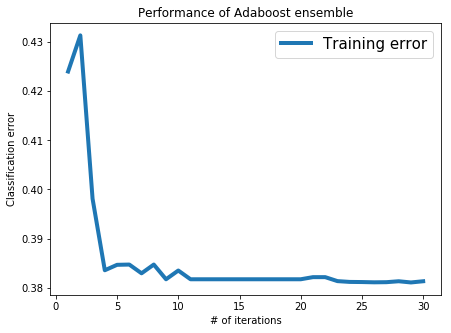

In [253]:
plt.rcParams["figure.figsize"] = 7, 5

plt.plot(range(1, 31), error_all, "-", linewidth=4.0, label="Training error")
plt.title("Performance of Adaboost ensemble")
plt.xlabel("# of iterations")
plt.ylabel("Classification error")
plt.legend(loc="best", prop={"size":15})

plt.rcParams.update({"font.size": 16})

### Evaluation on the test data

In [254]:
test_error_all = []

for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = sum(test_data[target] != predictions)/float(len(test_data))
    test_error_all.append(error)
    
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.419330453564
Iteration 2, test error = 0.427321814255
Iteration 3, test error = 0.397732181425
Iteration 4, test error = 0.378725701944
Iteration 5, test error = 0.382505399568
Iteration 6, test error = 0.382613390929
Iteration 7, test error = 0.3813174946
Iteration 8, test error = 0.382613390929
Iteration 9, test error = 0.379913606911
Iteration 10, test error = 0.38120950324
Iteration 11, test error = 0.379913606911
Iteration 12, test error = 0.379913606911
Iteration 13, test error = 0.379913606911
Iteration 14, test error = 0.379913606911
Iteration 15, test error = 0.379913606911
Iteration 16, test error = 0.379913606911
Iteration 17, test error = 0.379913606911
Iteration 18, test error = 0.379913606911
Iteration 19, test error = 0.379913606911
Iteration 20, test error = 0.379913606911
Iteration 21, test error = 0.380345572354
Iteration 22, test error = 0.380345572354
Iteration 23, test error = 0.381749460043
Iteration 24, test error = 0.379589632829
Iter

### Visualize both the training and test errors

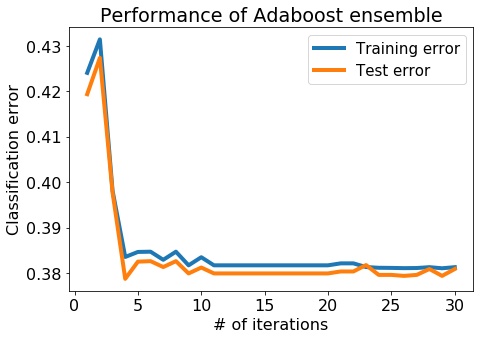

In [255]:
plt.rcParams["figure.figsize"] = 7, 5

plt.plot(range(1, 31), error_all, "-", linewidth=4.0, label="Training error")
plt.plot(range(1, 31), test_error_all, "-", linewidth=4.0, label="Test error")

plt.title("Performance of Adaboost ensemble")
plt.xlabel("# of iterations")
plt.ylabel("Classification error")
plt.rcParams.update({"font.size": 16})
plt.legend(loc="best", prop={"size": 15})

plt.tight_layout()